# Neural Machine Translator

In this notebook I will create the sequence-to-sequence translation system in Tensorflow. This will be done using single-layer encoder and decoder architecture, without using the Tensorflow native seq-to-seq modules. The method is heavily inspired by [these tutorials](https://github.com/ematvey/tensorflow-seq2seq-tutorials), particularly the implementation of previously fed tokens into the `tf.nn.raw_rnn` as proposed in the second tutorial. My code goes one step further and is able to feed in either the _ground truth_, previously generated tokens or a random combination of the two. While feeding in only the ground truth speeds up training and passing previously generated tokens increases robustness and performance, a combination of the two has been shown to interpolate between these two extremes. My NMT implementation was benchmarked against a direct dictionary based method using the [GoogleTrans](https://pypi.python.org/pypi/googletrans) API.

## Loading the preprocessed data

In [2]:
lang_t = 'en'
lang_s = 'fr'
prep_path = "DATA/"

In [3]:
import logging
import os
import numpy as np
from utils import *
logging.getLogger("tensorflow").setLevel(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
logging.basicConfig(level=logging.DEBUG, filename="logfile", filemode="a+",
                        format="%(asctime)-15s %(levelname)-8s %(message)s")

data_path = ""
data_dict = load_obj(data_path+'data_dic')
s_train = data_dict["s_train"]
t_train = data_dict["t_train"]
s_test = data_dict["s_test"]
t_test = data_dict["t_test"]
word2id_s = data_dict["word2id_s"]
word2id_t = data_dict["word2id_t"]
id2word_s = data_dict["id2word_s"]
id2word_t = data_dict["id2word_t"]

vocab_size_t = len(word2id_t.keys())
vocab_size_s = len(word2id_s.keys())

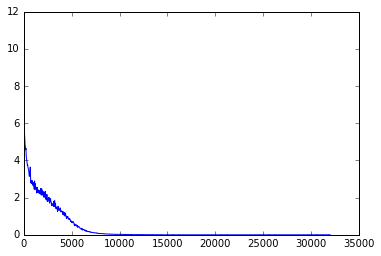

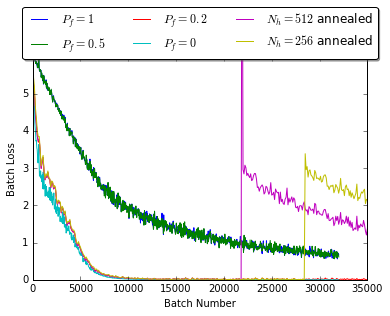

In [41]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from utils import *
l_a= load_obj("DATA/loss_track_a")
l_b= load_obj("DATA/loss_track_b")
l_c= load_obj("DATA/loss_track_c")
l_58= load_obj("DATA/loss_track_58")
l_59= load_obj("DATA/loss_track_59")
l_61= load_obj("DATA/loss_track_61")
l_62= load_obj("DATA/loss_track_62")
while len(l_c)< len(l_b):
    l_c.append(0)
#l_128
batches = 35000/51
ticks = [(batches*i, i) for i in range(1,51)]
fig = plt.figure()

plt.plot(30*np.arange(0,len(l_c)),l_c, label='$P_f=0$')
#plt.
fig = plt.figure()
T = 100*np.arange(0,len(l_58))
plt.plot(30*np.arange(0,len(l_a)),l_a, label='$P_f=1$' )
plt.plot(30*np.arange(0,len(l_b)),l_b, label='$P_f=0.5$')
plt.plot(T,l_62, label=r"$P_f=0.2$")
plt.plot(30*np.arange(0,len(l_c)),l_c, label='$P_f=0$')
plt.plot(T,l_58, label=r"$N_h=512$ annealed")
plt.plot(T,l_59, label=r"$N_h=256$ annealed")

#plt.plot(T,l_61, label=r"$N_h=256$, $P_f=0.2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=3, fancybox=True, shadow=True)
plt.ylabel('Batch Loss')
plt.xlabel('Batch Number')
plt.xlim(0,35000)
plt.ylim(0,6)
plt.show()


In [42]:
print(min(l_59))

0.0016398


## Load the preprocessed datasets
Need the preprocessed data, the id_to_word dictionaries and word_to_id dictionaries for both source and target languages.

## Evaluation metric:     BLEU Score

Here I use the NLTK implementation of BLEU score to measure how successful the machine translation was.

In [ ]:
from nltk.translate import bleu_score
from utils import remove_EOS_PAD

p_phrase1 = [4,5,4,5,4,5, 1, 0]
t_phrase = [4,5,6,34,8,76, 87, 1]
# Truncate sequences at [1]
t_phrase = remove_EOS_PAD(t_phrase)
p_phrase1 = remove_EOS_PAD(p_phrase1)

print "BLEU1 score test is {}.".format(
    bleu_score.corpus_bleu([[t_phrase]], [p_phrase1], weights=([1])))
print "BLEU2 score test is {}.".format(
    bleu_score.corpus_bleu([[t_phrase]], [p_phrase1], weights=([0.5,0.5])))

## Benchmark model

Here I use the [GoogleTrans]() python package to translate the corpus by translating each individual word in the text. There seems to be an issue with the number of JSON requests the model makes to the Google Translate service, so it needs to work in passes. If a phrase is skipped due to a JSON error, keep it stored and try again later (with a new Translator instance).

In [75]:
from googletrans import Translator


def googletrans_pass(s_text, target_lang='fr'):
    translator = Translator()
    trans_corpus = []
    skipped_phrases = []
    for i, phrase in s_text:
        try:
            trans_corpus.append((i, [trans.text for 
                            trans in translator.translate(phrase, dest=target_lang)]))
        except ValueError as err:
            # Making a new Translator instance seems to help JSON errors
            translator = Translator()
            skipped_phrases.append((i, phrase))
            print "{} for phrase {}".format(err, i)
    return trans_corpus, skipped_phrases

def translate_word_by_word(source_text):
    # Need to keep track of phrase ordering by labelling
    source_text = [(i, phr) for i, phr in enumerate(source_text)]
    trans_text, skipped_phrases = googletrans_pass(source_text, target_lang=lang_t)
    print "There are {} phrases which could not be translated first time around.".format(
                                                                    len(skipped_phrases))
    # Keep making passes until there are no more untranslated phrases left
    j = 2
    while len(skipped_phrases)>0:
        translated_corpus = []
        tc_s, skipped_phrases = googletrans_pass(skipped_phrases, target_lang=lang_t)
        trans_text += tc_s
        print "There are {} phrases which could not be translated in pass {}.".format(
                                                            len(skipped_phrases), j)
        j+=1
    # Sort the phrases via their labels.
    # Sorted function gives ([indices], [phrases]) so just need 2nd element
    trans_text = zip(*sorted(zip(*BM_translated)))[1]
    return trans_text

BM_translated = translate_word_by_word(raw_source_test)
print "Corpus translated from {} to {}".format(lang_s, lang_t)


No JSON object could be decoded for phrase 46
No JSON object could be decoded for phrase 87
No JSON object could be decoded for phrase 132
No JSON object could be decoded for phrase 166
No JSON object could be decoded for phrase 217
No JSON object could be decoded for phrase 263
No JSON object could be decoded for phrase 316
No JSON object could be decoded for phrase 373
No JSON object could be decoded for phrase 430
No JSON object could be decoded for phrase 479
No JSON object could be decoded for phrase 526
No JSON object could be decoded for phrase 581
No JSON object could be decoded for phrase 630
No JSON object could be decoded for phrase 683
No JSON object could be decoded for phrase 742
No JSON object could be decoded for phrase 798
No JSON object could be decoded for phrase 1025
No JSON object could be decoded for phrase 1074
No JSON object could be decoded for phrase 1117
No JSON object could be decoded for phrase 1329
No JSON object could be decoded for phrase 1519
No JSON ob

KeyboardInterrupt: 

In [74]:
print " ".join(raw_source_test[60])
print " ".join(BM_translated[60])
print " ".join(raw_target_test[60])

Une des raisons de l&apos; échec de &quot; The Hunting Party &quot; est que l&apos; on ne laisse simplement pas Simon Hunt être le cynique déserté doté d&apos; un cœur , comme il nous est présenté au début .
A of the reasons from l&apos; failure from &quot; The Hunting Party &quot; East what l&apos; on born leash simply not Simon Hunt be the cynical deserted with d&apos; a heart , as the we East present the beginning .
One of the reasons why &quot; The Hunting Party &quot; fails is that Simon Hunt isn &apos;t allowed to simply be the run-down cynic with a heart of gold we &apos;re introduced to at the beginning .


In [ ]:
test_targets = [[ids_to_phrases(phrase,id_to_word_t)]for phrase in test_t]

BM_BLEU4 = bleu_score.corpus_bleu(test_targets, BM_translated, weights=(0.25,0.25, 0.25,0.25))
BM_BLEU2 = bleu_score.corpus_bleu(test_targets, BM_translated, weights=(0.5,0.5))
BM_BLEU1 = bleu_score.corpus_bleu(test_targets, BM_translated, weights=([1]))

print "Actual: \n", (" ".join(test_targets[10])).encode('utf-8')
print "Prediction: \n", (" ".join(BM_translated_corp[10])).encode('utf-8')
print "Unigram BLEU score is {}.".format(BM_BLEU1)
print "Bigram BLEU score is {}.".format(BM_BLEU2)
print "4-Gram BLEU: {}".format(BM_BLEU4)

# Word IDs and word-to-vec vectors

Since we are interested in the process of learning weights within the RNNs to predict seq2seq mappings rather than embeddings I have chosen to use pretrained word embeddings ino order to cut down training time. [THis is](https://sites.google.com/site/rmyeid/projects/polyglot#TOC-Download-the-Embeddings) where the embeddings are from.

In [8]:
import pickle
import numpy as np
def get_embeddings(id_to_word, lang):
    # We load pretrained word2vec embeddings from polyglot to save on training time
    filename ='DATA/polyglot-'+lang+'.pkl'
    pretrain_vocab, pretrain_embed = pickle.load(open(filename, 'rb'))
    embed_vocab = [pretrain_embed[pretrain_vocab.index('<PAD>')], pretrain_embed[pretrain_vocab.index('</S>')]]
    skip_count = 0
    skipped_words = []
    for idx, word in sorted(id_to_word.items()[2::]):
        try:
            pretrain_idx = pretrain_vocab.index(word)
            embed_vocab.append(pretrain_embed[pretrain_idx])
        except ValueError:
            try:
                # it could be that the word is a name which needs to 
                # be capitalized. Try this...
                pretrain_idx = pretrain_vocab.index(str(word.title()))
                embed_vocab.append(pretrain_embed[pretrain_idx])
            except ValueError:
                try:
                    # it could be that the word is an achronym which needs to 
                    # be upper case. Try this...
                    pretrain_idx = pretrain_vocab.index(word.upper())
                    embed_vocab.append(pretrain_embed[pretrain_idx])
                except ValueError:
                    # Give up trying to find an embedding.
                    # How many words are skipped? Which ones?
                    skip_count +=1
                    skipped_words.append(word)
                    # Let's just initialise the embedding to a random normal distribution
                    embed_vocab.append(np.random.normal(loc=0.0, scale=np.sqrt(2)/4, size=64))
    embed_vocab = np.array(embed_vocab, dtype=np.float32)
    print "The embedding matrix for {} has {} columns and {} rows.".format(lang, 
                                                embed_vocab.shape[0], embed_vocab.shape[1])
    print "{} vocab words were not in the {} embeddings file.".format(skip_count, lang)
    return embed_vocab, skipped_words
# the ith word in words corresponds to the ith embedding 

embed_vocab_s, skipped_s = get_embeddings(id2word_s, lang=lang_s)
embed_vocab_t, skipped_t = get_embeddings(id2word_t, lang=lang_t)
print skipped_t

The embedding matrix for fr has 25003 columns and 64 rows.
3093 vocab words were not in the fr embeddings file.
The embedding matrix for en has 20003 columns and 64 rows.
2001 vocab words were not in the en embeddings file.
[u'&#93', u'&#91', u'impoverishment', u'ebrd', u'co-operation', u'at-sea', u'south-west', u'17000', u'high-performing', u'275', u'receivables', u'counter-terrorism', u'three-', u'2008-2009', u'&aposll', u'99', u'tangles', u'91', u'90', u'95', u'94', u'97', u'genevi\xe8ve', u'f\xe9in', u'double-edged', u'that..', u'peacebuilding', u'pyjamas', u'18th', u'1-15', u'lower-cost', u'amnesty..', u'eighty-six', u'accrual', u'hizbollah', u'coronavirus', u'shutdowns', u'no.5', u'underfoot', u'shipper', u'1970s', u'no.8', u'loss-making', u'wasn', u'172', u'170', u'202', u'mckinsey', u'205', u'cross-reference', u'&aposconnor', u'megadroid', u'2012-2013', u'khrushcheva', u'cross-examination', u'rou\u010dek', u'reschedule', u'five-week', u'hi-tech', u'year-on-year', u'pre-empt', u

** We can see above ** that the English words which were not in the embedding files are fairly specialist words or numerical values (which are the same in French) so hopefully they won't be too much of a problem.

In [49]:
#from utils import format_batch
test_x = [[5,2,3],[2], [4,2], [1,2]]
# it's going to go from the number of cols being the sequence length/ num of rows being batch size
# to the number of rows being the max sequence length/ num cols being batch size
# Essentially like a padding and then transpose
def format_batch(x):
    seq_lengths = [len(row) for row in x]
    n_batches = len(x)
    max_seq_length = max(seq_lengths)
    outputs = np.zeros(shape=(max_seq_length, n_batches),dtype=np.int32)
    for i in range(len(seq_lengths)):
        for j in range(seq_lengths[i]):
            outputs[j][i] = x[i][j]
    return outputs

print format_batch(test_x)
print np.array(format_batch(source_train[0:7]))

[[5 2 4 1]
 [2 0 2 2]
 [3 0 0 0]]
[[ 7918  9196  7408 10623  6866 14876 10007]
 [15966 17183 14549 23542  8267 18930 13305]
 [20240  3810 16068 10829 11873  9616 10517]
 [ 9137  8267 10538  8267     1 19096 15796]
 [  403 24855 21589  2632     0 10829  7684]
 [ 5294  8279  7408 15796     0 17741 11297]
 [11271 20581 16270  9070     0  3162 12933]
 [ 6054 10619 19982 11271     0 20845  4351]
 [10007  2904  4820     2     0     1 16358]
 [13517     1  7408  8279     0     0 19096]
 [  190     0  4782  7948     0     0 20565]
 [16358     0  4409 14199     0     0     1]
 [19096     0 15966     1     0     0     0]
 [24224     0  8716     0     0     0     0]
 [16392     0   976     0     0     0     0]
 [    1     0 19096     0     0     0     0]
 [    0     0 13537     0     0     0     0]
 [    0     0 19984     0     0     0     0]
 [    0     0 19096     0     0     0     0]
 [    0     0  2712     0     0     0     0]
 [    0     0 12276     0     0     0     0]
 [    0     0     2  

Very pleasing...

# Building the network

In [29]:
import tensorflow as tf

tf.reset_default_graph()
input_embedding_size = 64 # Fixed due to pretrained embedding files
encoder_hidden_units = 128
decoder_hidden_units = encoder_hidden_units # Must be the same at the moment

In [30]:

encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')
encoder_inputs_embedded = tf.nn.embedding_lookup(embed_vocab_s, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embed_vocab_t, decoder_inputs)
with tf.device("/cpu:0"):
    encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_inputs_embedded,
                                                     dtype=tf.float32, time_major=True)
with tf.device("/cpu:1"):
    decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

    decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                    decoder_cell, decoder_inputs_embedded,
                    initial_state=encoder_final_state,
                    dtype=tf.float32, time_major=True,
                    scope="plain_decoder")
    decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size_t)
    """
    #weights
    W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size_t], -0.5, 0.5), dtype=tf.float32)
    #bias
    b = tf.Variable(tf.zeros([vocab_size_t]), dtype=tf.float32)
    decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
    # why do we only flatten the tensor so it's rank 2?
    decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
    #feed flattened tensor through projection
    decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
    # make the logits the shape of the
    decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size_t))
    """
with tf.device("/cpu:2"):
    decoder_prediction = tf.argmax(decoder_logits, axis=2)
    timestep_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.one_hot(decoder_targets, depth=vocab_size_t,
                          dtype=tf.float32),logits=decoder_logits)
    print timestep_cross_entropy
    # loss is the mean of the cross entropy
    loss = tf.reduce_mean(timestep_cross_entropy)
    tf.summary.scalar('loss', loss)
    # We use AdaM which combines AdaGrad (parameters updated less often get updated more 	strongly)
    # and momentum (updates depend on the slope of previous updates - avoiding local minima)
    train_op = tf.train.AdamOptimizer().minimize(loss)

Tensor("Reshape_2:0", shape=(?, ?), dtype=float32, device=/device:CPU:2)


In [31]:
"""#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size_t], -0.5, 0.5), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size_t]), dtype=tf.float32)
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
# why do we only flatten the tensor so it's rank 2?
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#feed flattened tensor through projection
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
# make the logits the shape of the 
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size_t))

print decoder_logits"""

"#weights\nW = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size_t], -0.5, 0.5), dtype=tf.float32)\n#bias\nb = tf.Variable(tf.zeros([vocab_size_t]), dtype=tf.float32)\ndecoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))\n# why do we only flatten the tensor so it's rank 2?\ndecoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))\n#feed flattened tensor through projection\ndecoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)\n# make the logits the shape of the \ndecoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size_t))\n\nprint decoder_logits"

In [32]:
def batch_source_target(source, target, batch_size):
    assert len(source) == len(target)
    for start in range(0, len(source), batch_size):
        end = min(start + batch_size, len(source))
        #print type(source[start:end])
        #print len(target[start:end])
        yield source[start:end], target[start:end]


def make_feed_dict(fd_keys, s_batch, t_batch, reverse_encoder_inputs= False):
    encoder_inputs_ = format_batch(s_batch)
    if reverse_encoder_inputs:
        encoder_inputs_ = format_batch([sequence[-2::-1]+[1] for sequence in s_batch])
    decoder_inputs_ = format_batch([[1]+sequence[0:-1] for sequence in t_batch])
    decoder_targets_ = format_batch([sequence for sequence in t_batch])
    return {
        fd_keys[0]: encoder_inputs_,
        fd_keys[1]: decoder_inputs_,
        fd_keys[2]: decoder_targets_,
    }



def make_test_feed_dict(fd_keys,s_batch, t_batch, reverse_encoder_inputs= False):
    # At testing time, we can't supervise the decoder layer with
    # the 'gold truth' example as input, so we instead feed in
    # word generated at  previous timestep. This is (apparently)
    # equivalent to feeding in zeros for the decoder inputs
    encoder_inputs_ = format_batch(s_batch)
    if reverse_encoder_inputs:
        encoder_inputs_ = format_batch([sequence[-2::-1]+[1] for sequence in s_batch])
    decoder_targets_ = format_batch([sequence for sequence in t_batch])
    decoder_inputs_ = format_batch([[0]*len(sequence) for sequence in t_batch])
    return {
        fd_keys[0]: encoder_inputs_,
        fd_keys[1]: decoder_inputs_,
        fd_keys[2]: decoder_targets_,
    }

# Test everything is working okay

batch_size = 100

for s_sample_batch, t_sample_batch in batch_source_target(s_train[0:2], t_train[0:2], batch_size):
    fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]
    fd = make_feed_dict(fd_keys, s_sample_batch, t_sample_batch)
    fd_r = make_feed_dict(fd_keys, s_sample_batch, t_sample_batch, reverse_encoder_inputs= True)
    fd_t = make_test_feed_dict(fd_keys, s_sample_batch, t_sample_batch, reverse_encoder_inputs= False)
    assert len(fd.values()[0].T[0]) == len(fd_r.values()[0]) # reversed list must be the same length as original
    print fd.keys()[0]
    print ids_to_phrases(np.array(fd.values()[0]).T[0], id2word_s)
    print np.array(fd.values()[0]).T[0], "\n"
    #print "Reversed as in Sutskever et al. "
    #print np.array(fd_r.values()[0]).T[0]
    assert len(fd.values()[1].T[0]) == len(fd.values()[1].T[1]) # decoder inputs and targets must be the same
    for i in range(1, len(fd.keys())):
        print fd.keys()[i]
        ph = ids_to_phrases(np.array(fd.values()[i]).T[0], id2word_t)
        print ph
        print np.array(fd.values()[i]).T[0]
    
    print "Decoder inputs at test time"
    print np.array(fd_t.values()[1]).T[0]
    break


Tensor("encoder_inputs:0", shape=(?, ?), dtype=int32)
they qwerty scandinaves transmissibles disposés supprimés surcharge audacieuse chaotique normale eût chris dauphins derrick peints 
[ 7918 15966 20240  9137   403  5294 11271  6054 10007 13517   190 16358
 19096 24224 16392     1] 

Reversed as in Sutskever et al. 
[16392 24224 19096 16358   190 13517 10007  6054 11271  5294   403  9137
 20240 15966  7918     1]
Tensor("decoder_inputs:0", shape=(?, ?), dtype=int32)

[    1  1565  7485  6620 19749  1045   262 11773  9713 12656   974  2425
 12834  2524  3982 16733]
Tensor("decoder_targets:0", shape=(?, ?), dtype=int32)
misplaced ridden drop know attendees hot lap sofia compilation bnp follow-up théâtre midwest bent skillfully 
[ 1565  7485  6620 19749  1045   262 11773  9713 12656   974  2425 12834
  2524  3982 16733     1]
Decoder inputs at test time
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [28]:
loss_track = []

[u'<PAD>', u'<EOS>', u'<UNK>', u'accueille', u'woods', u'accueilli', u'yougoslavie', u'&#93', u'&#91', u'lib\xe9r\xe9s', u'embl\xe9matiques', u'lib\xe9r\xe9e', u'd\xe9verser', u'savaient', u'touristes', u'adoptent', u'consid\xe9rable', u'liaisons', u'pr\xe9c\xe9d\xe9', u'controvers\xe9', u'chaussure', u'270', u'miniatures', u'274', u'275', u'276', u'n\u0153ud', u'resserrement', u'originalit\xe9', u'recyclage', u'familles', u'st\xe9r\xe9otypes', u'abr\xe9viations', u'pourparlers', u'chine', u'china', u'kids', u'm\xe9tabolisme', u'naturel', u'a\xe9riens', u'controverse', u'kidd', u'nomades', u'golden', u'projection', u'p\xe9cheur', u'comp\xe9titives', u'modifi\xe9s', u'traiteur', u'2.2.1', u'stern', u'modifi\xe9e', u'sensibilisation', u'dna', u'transport\xe9e', u'1892', u'music', u'holistique', u'voyageur', u'comp\xe9titions', u'populations', u'yahoo', u'kampala', u'commentaire', u'observateurs', u'h\xe9ritier', u'avaient', u'wang', u'merveilleuses', u'th\xe9oriquement', u'rythme', u'bie

In [60]:
import time

def format_idx(idx):
    # Just cuts out the padding of word index lists
    li = []
    for i in idx:
        if i ==0:
            break
        else:
            li.append(i)
    return li

BLEU = []
epochs = 30 # How many times we loop over the whole training data
batch_size = 92 # After how many sequences do we update the weights?
print "there will be {} samples in the final batch".format(len(source_train)%batch_size)
fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]
try:
    batch_n = 0
    ti = time.time()
    print "training has begun..."
    for epoch in range(1,epochs+1):    
        for s_batch, t_batch in batch_source_target(source_train, target_train, batch_size):
            feed_dict = make_feed_dict(fd_keys, s_batch, t_batch)
            _, l = sess.run([train_op, loss], feed_dict)
            if (batch_n==0) or (batch_n%100) == 0:
                loss_track.append(l)
                print "epoch {}".format(epoch)
                print 'batch {}'.format(batch_n)
                print 'loss: {}'.format(sess.run(loss, feed_dict))
                predict_ = sess.run(decoder_prediction, feed_dict)
                #predictions = [remove_EOS_PAD(pred) for pred in predict_.T]
                #actuals = [[remove_EOS_PAD(act)] for act in fd[decoder_targets].T]
                #BLEU2 = bleu_score.corpus_bleu(actuals, predictions, weights=(0.5,0.5))
                #BLEU.append(BLEU2)
                i =1
                for (inp, act, pred) in zip(feed_dict[encoder_inputs].T,
                                                         feed_dict[decoder_targets].T,
                                                         predict_.T)[10:12]:
                    print '  sample {}:'.format(i)
                    print '    input     > {} \n {}'.format(
                        format_idx(inp), ids_to_phrases(inp, id2word_s))
                    print '    actual     > {} \n {}'.format(
                        format_idx(act), ids_to_phrases(act, id2word_t))
                    print '    predicted     > {} \n {}'.format(
                        format_idx(pred), ids_to_phrases(pred, id2word_t))
                    i+=1
            batch_n += 1
            
    print 'Training is complete'
except KeyboardInterrupt:
    print 'training interrupted'



there will be 64 samples in the final batch
training has begun...
epoch 1
batch 0
loss: 1.89692986012
  sample 1:
    input     > [1187, 1529, 1703, 4602, 2, 3396, 1078, 1703, 2, 718, 3556, 2644, 2433, 1187, 3503, 1538, 2, 1170, 4970, 226, 1] 
 l&apos; associé de m. <UNK> s&apos; occupe de <UNK> au canada est aussi l&apos; agent qui <UNK> les fournisseurs . 
    actual     > [2077, 2, 286, 2344, 4404, 3255, 3499, 707, 5482, 3443, 2, 1022, 243, 1] 
 mr. <UNK> has a partner in canada as his agent <UNK> suppliers . 
    predicted     > [1784, 2, 2, 2, 2, 5233, 1784, 2, 2, 2, 5233, 2, 243, 1] 
 the <UNK> <UNK> <UNK> <UNK> of the <UNK> <UNK> <UNK> of <UNK> . 
  sample 2:
    input     > [2355, 941, 2118, 3146, 4276, 4902, 1703, 1362, 1098, 2, 1410, 1098, 3108, 2, 226, 1] 
 a première vue , la profondeur de ce &quot; <UNK> politique &quot; semble <UNK> . 
    actual     > [708, 3516, 2, 3089, 1784, 2613, 5233, 1191, 1084, 3483, 4038, 1084, 5198, 3575, 243, 1] 
 at first <UNK> , the depth of 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(loss_track)), loss_track)
#l = [s for i,s in sorted(zip([len(row) for row in l], l))]

# Results
With a `feed_previous` probability of 0.7, where 70% of the decoder inputs are previously generated tokens, after only around 6 epochs the model is making predictions which are more accurate than some of the data, for example: 

`Source: scrutin du jour du lendemain le h 9 
actual: there is a tie or difference between first 2 candidates is less than 10 votes - 
predicted:  9 are no day in a between the day months`

where the English translation is is totally incorrect and is obviously just some error in the dataset, however the NMT prediction is in the right ball-park. The google translate answer is "9:00 am the day after polling day".

After 12 epochs, the model makes predictions with a very similar meaning to the correct translation but expressed differently

`Actual: some 15 of the park's native mammal species are considered rare threatened or endangered 
predicted: several of percent the species's marine mammal species are rare threatened or or endangered`
